In [2]:
import sys
sys.path.append('/Users/berke/Codes/python/flann/src/python')
sys.path.append('/Users/berke/Codes/scaman/scaman')
import numpy as np
import sklearn
from serial.le_flann import LE


In [3]:
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import rbf_kernel

def compute_affinity_matrix_sklearn(X, k=7, sigma=1.0):
    """
    Computes the affinity matrix (W) for a given dataset X using a Gaussian kernel.

    Parameters:
    X (numpy array): Input dataset of shape (n_samples, n_features).
    k (int): Number of nearest neighbors to consider for each data point.
    sigma (float): Width of the Gaussian kernel.

    Returns:
    W (numpy array): Affinity matrix of shape (n_samples, n_samples).
    """
    A = kneighbors_graph(X, k, mode='connectivity', include_self=True)
    W = rbf_kernel(X, gamma=1.0/(2*sigma**2))
    W *= A.toarray()
    return W

In [7]:
import numpy as np
import networkx as nx
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Generate a random dataset
X, _ = make_blobs(n_samples=100, centers=3, n_features=2, random_state=42)

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Compute the affinity matrices using different methods
le = LE(X, k=5, sigma=1.0,affinity='numpy')
W1 = le._compute_affinity_matrix()
le = LE(X, k=5, sigma=1.0,affinity='networkx')
W2 = le._compute_affinity_matrix_networkx()
le = LE(X, k=5, sigma=1.0,affinity='flann')
W3 = le._compute_affinity_matrix_flann()
W4 = compute_affinity_matrix_sklearn(X, k=7, sigma=1.0)

# Compare the affinity matrices
print(np.allclose(W1, W4))
print(np.allclose(W2, W4))
print(np.allclose(W3, W4))

False
False
False


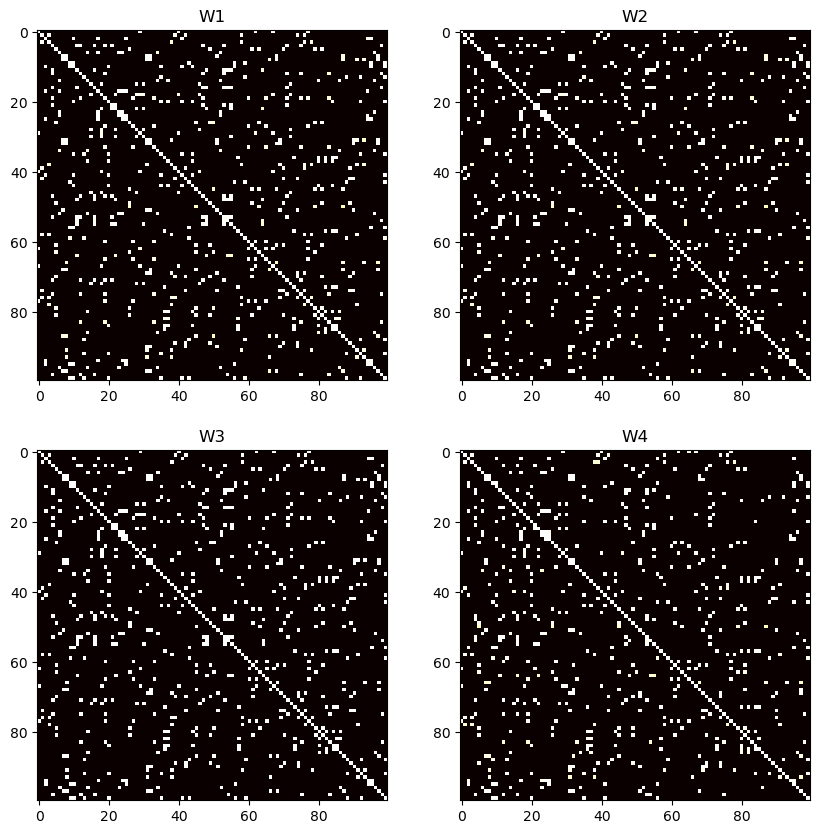

In [8]:
import matplotlib.pyplot as plt

# Plot the affinity matrices
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(W1, cmap='hot', interpolation='nearest')
axs[0, 0].set_title('W1')
axs[0, 1].imshow(W2, cmap='hot', interpolation='nearest')
axs[0, 1].set_title('W2')
axs[1, 0].imshow(W3, cmap='hot', interpolation='nearest')
axs[1, 0].set_title('W3')
axs[1, 1].imshow(W4, cmap='hot', interpolation='nearest')
axs[1, 1].set_title('W4')
plt.show()

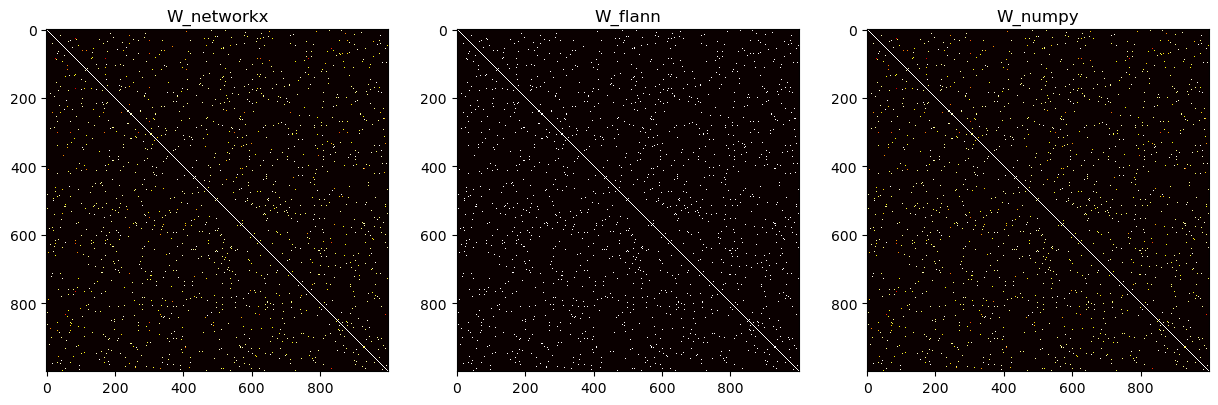

Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 451
Solution method: arnoldi
Number of requested eigenvalues: 2
Stopping condition: tol=1e-15, maxit=10000
Number of converged eigenpairs 2

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- ------------------
    -0.000000           177.034
    -0.000000           3686.61

Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 193
Solution method: krylovschur
Number of requested eigenvalues: 2
Stopping condition: tol=1e-15, maxit=10000
Number of converged eigenpairs 8

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- ------------------
     0.000000           16.8867
     0.000000           9.50187
     0.005098       3.75998e-12
     0.005465       3.01363e-12
     0.018550       9.10747e-13
     0.021847  

In [12]:
from sklearn.datasets import make_moons
from sklearn.metrics import pairwise_distances
from scipy.sparse.linalg import eigsh
import time

def test_affinity_matrix_functions():
    # Generate some test data
    X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

    # Compute the affinity matrix using different functions
    le = LE(X, k=10, sigma=0.1, solver='numpy', affinity='networkx', normalize=True)
    W_networkx = le._compute_affinity_matrix_networkx()

    le = LE(X, k=10, sigma=0.1, solver='numpy', affinity='flann', normalize=True)
    W_flann = le._compute_affinity_matrix_flann()

    le = LE(X, k=10, sigma=0.1, solver='numpy', affinity='numpy', normalize=True)
    W_numpy = le._compute_affinity_matrix()

    # Compute the affinity matrix using pairwise_distances
    distances = pairwise_distances(X)
    W_pairwise = np.exp(-distances ** 2 / (2 * 0.1 ** 2))

    # Check that the affinity matrices are equal
    #assert np.allclose(W_networkx, W_flann, rtol=1e-3, atol=1e-3)
    #assert np.allclose(W_networkx, W_pairwise, rtol=1e-3, atol=1e-3)

    # Heat maps of the affinity matrices
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(W_networkx, cmap='hot', interpolation='nearest')
    axs[0].set_title('W_networkx')
    axs[1].imshow(W_flann, cmap='hot', interpolation='nearest')
    axs[1].set_title('W_flann')
    axs[2].imshow(W_numpy, cmap='hot', interpolation='nearest')
    axs[2].set_title('W_numpy')
    plt.show()


def test_eigensolvers():
    # Generate some test data
    X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

    # Compute the embedding using different eigensolvers
    le = LE(X, k=10, sigma=0.1, solver='numpy', affinity='networkx', normalize=False)
    Y_numpy = le.fit_transform()

    le = LE(X, k=10, sigma=0.1, solver='scipy', affinity='networkx', normalize=False)
    Y_scipy = le.fit_transform()

    le = LE(X, k=10, sigma=0.1, solver='slepc', slepc_solver='ARNOLDI', affinity='networkx', normalize=False)
    Y_slepc = le.fit_transform()

    # Check that the embeddings are equal
    #assert np.allclose(Y_numpy, Y_scipy, rtol=1e-3, atol=1e-3)
    #assert np.allclose(Y_numpy, Y_slepc, rtol=1e-3, atol=1e-3)

def test_affinity_matrix_functions_and_eigensolvers():
    # Generate some test data
    X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

    # Compute the embedding using different affinity matrix functions and eigensolvers
    le = LE(X, k=10, sigma=0.1, solver='numpy', slepc_solver='KRYLOVSCHUR', affinity='networkx', normalize=False)
    start_time = time.time()
    Y_networkx_numpy = le.fit_transform()
    end_time = time.time()
    time_networkx_numpy = end_time - start_time

    le = LE(X, k=10, sigma=0.1, solver='scipy', slepc_solver='KRYLOVSCHUR', affinity='networkx', normalize=False)
    start_time = time.time()
    Y_networkx_scipy = le.fit_transform()
    end_time = time.time()
    time_networkx_scipy = end_time - start_time

    le = LE(X, k=10, sigma=0.1, solver='slepc', slepc_solver='KRYLOVSCHUR', affinity='networkx', normalize=False)
    start_time = time.time()
    Y_networkx_slepc = le.fit_transform()
    end_time = time.time()
    time_networkx_slepc = end_time - start_time

    le = LE(X, k=10, sigma=0.1, solver='numpy', slepc_solver='KRYLOVSCHUR', affinity='flann', normalize=False)
    start_time = time.time()
    Y_flann_numpy = le.fit_transform()
    end_time = time.time()
    time_flann_numpy = end_time - start_time

test_affinity_matrix_functions()
test_eigensolvers()
test_affinity_matrix_functions_and_eigensolvers()